# Challenge
Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. First, load the dataset.

2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
# Load the dataset
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

expectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# No need for an open connection, as we're only doing a single query
engine.dispose()

## Detect and Correct Problems

In [3]:
# Make columns names consistent by removing leading/trailing 
# spaces, replacing internal spaces with _, and making lowercase
original_columns = list(expectancy_df.columns)
new_columns = []

for column in original_columns:
    new_columns.append(column.strip().replace('  ', ' ').replace(' ', '_').lower())

expectancy_df.columns = new_columns

In [4]:
# Rename thinness_1-19_years thinness_10-19 years
expectancy_df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

columns = list(expectancy_df.columns)

In [5]:
# Verify variable name changes
expectancy_df

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [6]:
# Check overall stats for each variable
expectancy_df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


I have decided to change the following values to null because they simply do not make sense as they stand in the original data:

1. Adult mortality ratio lower than the 5th percentile (unlikely to have adult mortality ratios of 1)
2. Infant deaths of 0 (unlikely to have infant death ratios of 1)
3. BMI less than 5 and greater than 55 (unlikely to have bmi of 1 or 87.3)
4. Under five deaths of 0 (again, unlikely to have such low death ratios)

In [7]:
# Change unlikely values to null values
mortality_5th_percentile = np.percentile(expectancy_df['adult_mortality'].dropna(), 5)
expectancy_df['adult_mortality'] = expectancy_df.apply(lambda x: np.nan if x.adult_mortality < mortality_5th_percentile else x.adult_mortality, axis=1)

expectancy_df['infant_deaths'] = expectancy_df['infant_deaths'].replace(0, np.nan)

expectancy_df['bmi'] = expectancy_df.apply(lambda x: np.nan if (x.bmi < 5 or x.bmi > 55) else x.bmi, axis=1)

expectancy_df['under-five_deaths'] = expectancy_df['under-five_deaths'].replace(0, np.nan)

In [8]:
# Check data types for each variable
expectancy_df.dtypes

country                             object
year                                 int64
status                              object
life_expectancy                    float64
adult_mortality                    float64
infant_deaths                      float64
alcohol                            float64
percentage_expenditure             float64
hepatitis_b                        float64
measles                              int64
bmi                                float64
under-five_deaths                  float64
polio                              float64
total_expenditure                  float64
diphtheria                         float64
hiv/aids                           float64
gdp                                float64
population                         float64
thinness_10-19_years               float64
thinness_5-9_years                 float64
income_composition_of_resources    float64
schooling                          float64
dtype: object

In [9]:
# Check variable types
expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2783 non-null float64
infant_deaths                      2090 non-null float64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                1932 non-null float64
under-five_deaths                  2153 non-null float64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-

In [10]:
# Skim unique entries in each column
for column in columns:
    print(column)
    print(expectancy_df[column].unique())
    print(30 * '-')

country
['Afghanistan' 'Albania' 'Algeria' "Côte d'Ivoire" 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Slovakia'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran (Is

[19.1 18.6 18.1 17.6 17.2 16.7 16.2 15.7 15.2 14.7 14.2 13.8 13.4 13.
 12.6 12.2  nan 54.3 53.5 52.6 51.7  5.8 49.9 48.9 47.9 46.9 46.  45.
 55.  19.9 53.9 52.8 51.8 49.8 47.  46.1 45.3 44.4 23.3 22.7 22.1 21.5
 21.  19.8 19.3 18.8 18.2 17.7 16.8 16.3 15.8 15.4 47.7 46.4 45.7 45.1
 43.8 43.2 42.6 42.  41.4 39.5 38.9 38.2  6.4 54.6 54.  54.9 54.1 53.3
 51.9 51.2  5.7  5.1 49.7 49.2 48.8 48.4 48.1 47.8 47.4 47.1  6.9  6.3
 54.7 54.2 53.7 53.2 52.7 52.2  5.6 52.5 51.5 48.  47.3 46.6 45.9 44.7
 44.2 43.6 43.1 42.1  6.7  6.1 54.4  6.8 54.8 54.5 18.3 17.  16.4 14.6
 14.  13.5 12.5 12.  11.6 11.2 53.  51.4 46.2 45.4 44.6 43.   6.5  6.6
  6.2  5.9 49.3 48.5 46.3 25.7 25.2 24.6 24.1 23.5 23.  22.5 22.  19.7
 19.2 18.4 24.5 23.6 21.9 21.1 19.5 18.  17.4 16.1 15.5 14.9 14.4 13.9
 48.6 46.7 44.  43.3 53.1 52.1 51.   5.5 49.4 48.2 47.6 37.9 37.3 36.8
 36.2 35.7 35.2 34.7 34.2 33.7 33.2 32.7 32.2 31.6 31.1 29.9 53.6 52.
 51.1  5.3 44.5 43.7 41.2 39.2 37.2 31.2 29.1 28.  27.  26.1 19.4 17.1
 16.6 15.

In [11]:
# Look at number of unique entries in each column
for column in columns:
    print(column)
    print(len(expectancy_df[column].unique()))
    print(30 * '-')

country
193
------------------------------
year
16
------------------------------
status
2
------------------------------
life_expectancy
363
------------------------------
adult_mortality
415
------------------------------
infant_deaths
209
------------------------------
alcohol
1077
------------------------------
percentage_expenditure
2328
------------------------------
hepatitis_b
88
------------------------------
measles
958
------------------------------
bmi
414
------------------------------
under-five_deaths
252
------------------------------
polio
74
------------------------------
total_expenditure
819
------------------------------
diphtheria
82
------------------------------
hiv/aids
200
------------------------------
gdp
2491
------------------------------
population
2279
------------------------------
thinness_10-19_years
201
------------------------------
thinness_5-9_years
208
------------------------------
income_composition_of_resources
626
----------------------------

In [12]:
# Use .isnull() to check for missing values
expectancy_df.isnull()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2935,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2936,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
# Find the fraction of missing values for each variable
# .isnull().count() includes missing values in the count
# .count() does not include missing values in the count
expectancy_df.isnull().sum() / expectancy_df.isnull().count() * 100

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     5.275698
infant_deaths                      28.863172
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                34.240980
under-five_deaths                  26.718856
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness_10-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

### Deal with Missing Values

In [14]:
# Fill in missing values using interpolation
expectancy_df1 = expectancy_df.copy()

columns_to_fill = ['life_expectancy', 'adult_mortality', 'infant_deaths',
                   'alcohol', 'hepatitis_b', 'bmi', 'under-five_deaths',
                   'polio', 'total_expenditure', 'diphtheria', 'gdp',
                   'population', 'thinness_10-19_years', 'thinness_5-9_years',
                   'income_composition_of_resources', 'schooling']

countries = expectancy_df1['country'].unique()

for country in countries:
    expectancy_df1.loc[expectancy_df1['country'] == country, columns_to_fill] = expectancy_df1.loc[expectancy_df1['country'] == country, columns_to_fill].interpolate()


In [15]:
expectancy_df1.isnull().sum() / expectancy_df1.isnull().count() * 100

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.476515
infant_deaths                      28.624915
alcohol                             6.535058
percentage_expenditure              0.000000
hepatitis_b                         4.901293
measles                             0.000000
bmi                                16.099387
under-five_deaths                  26.718856
polio                               0.000000
total_expenditure                   7.147720
diphtheria                          0.000000
hiv/aids                            0.000000
gdp                                14.363513
population                         22.191967
thinness_10-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [16]:
# Fill in missing values using interpolation
expectancy_df2 = expectancy_df.copy()

countries = expectancy_df2['country'].unique()

for country in countries:
    expectancy_df2.loc[expectancy_df2['country'] == country, columns_to_fill] = expectancy_df2.loc[expectancy_df2['country'] == country, columns_to_fill].interpolate()


In [17]:
expectancy_df2.isnull().sum() / expectancy_df2.isnull().count() * 100

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.476515
infant_deaths                      28.624915
alcohol                             6.535058
percentage_expenditure              0.000000
hepatitis_b                         4.901293
measles                             0.000000
bmi                                16.099387
under-five_deaths                  26.718856
polio                               0.000000
total_expenditure                   7.147720
diphtheria                          0.000000
hiv/aids                            0.000000
gdp                                14.363513
population                         22.191967
thinness_10-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [18]:
# Replace remaining missing values with mean of variable from countries of same status
for column in columns_to_fill:
    expectancy_df2[column] = expectancy_df2[column].fillna(expectancy_df2.groupby('status')[column].transform('mean'))

In [19]:
expectancy_df2.isnull().sum() / expectancy_df2.isnull().count() * 100

country                            0.0
year                               0.0
status                             0.0
life_expectancy                    0.0
adult_mortality                    0.0
infant_deaths                      0.0
alcohol                            0.0
percentage_expenditure             0.0
hepatitis_b                        0.0
measles                            0.0
bmi                                0.0
under-five_deaths                  0.0
polio                              0.0
total_expenditure                  0.0
diphtheria                         0.0
hiv/aids                           0.0
gdp                                0.0
population                         0.0
thinness_10-19_years               0.0
thinness_5-9_years                 0.0
income_composition_of_resources    0.0
schooling                          0.0
dtype: float64

In [20]:
# Replace missing values with mean of given variable
expectancy_df3 = expectancy_df.copy()

for column in columns_to_fill:
    expectancy_df3[column] = expectancy_df3[column].fillna(expectancy_df3[column].mean())

In [21]:
expectancy_df3.isnull().sum() / expectancy_df3.isnull().count() * 100

country                            0.0
year                               0.0
status                             0.0
life_expectancy                    0.0
adult_mortality                    0.0
infant_deaths                      0.0
alcohol                            0.0
percentage_expenditure             0.0
hepatitis_b                        0.0
measles                            0.0
bmi                                0.0
under-five_deaths                  0.0
polio                              0.0
total_expenditure                  0.0
diphtheria                         0.0
hiv/aids                           0.0
gdp                                0.0
population                         0.0
thinness_10-19_years               0.0
thinness_5-9_years                 0.0
income_composition_of_resources    0.0
schooling                          0.0
dtype: float64

In [22]:
# Replace missing values with mean of values from same country
expectancy_df4 = expectancy_df.copy()

for column in columns_to_fill:
    expectancy_df4[column] = expectancy_df4[column].fillna(expectancy_df4.groupby('country')[column].transform('mean'))

In [23]:
expectancy_df4.isnull().sum() / expectancy_df4.isnull().count() * 100

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                      25.936011
alcohol                             0.578625
percentage_expenditure              0.000000
hepatitis_b                         4.901293
measles                             0.000000
bmi                                 3.029272
under-five_deaths                  24.846835
polio                               0.000000
total_expenditure                   1.089176
diphtheria                          0.000000
hiv/aids                            0.000000
gdp                                13.784888
population                         22.055820
thinness_10-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [24]:
# Replace missing values with mean of variable from countries of same status
expectancy_df5 = expectancy_df.copy()

for column in columns_to_fill:
    expectancy_df5[column] = expectancy_df5[column].fillna(expectancy_df5.groupby('status')[column].transform('mean'))

In [25]:
expectancy_df5.isnull().sum() / expectancy_df5.isnull().count() * 100

country                            0.0
year                               0.0
status                             0.0
life_expectancy                    0.0
adult_mortality                    0.0
infant_deaths                      0.0
alcohol                            0.0
percentage_expenditure             0.0
hepatitis_b                        0.0
measles                            0.0
bmi                                0.0
under-five_deaths                  0.0
polio                              0.0
total_expenditure                  0.0
diphtheria                         0.0
hiv/aids                           0.0
gdp                                0.0
population                         0.0
thinness_10-19_years               0.0
thinness_5-9_years                 0.0
income_composition_of_resources    0.0
schooling                          0.0
dtype: float64

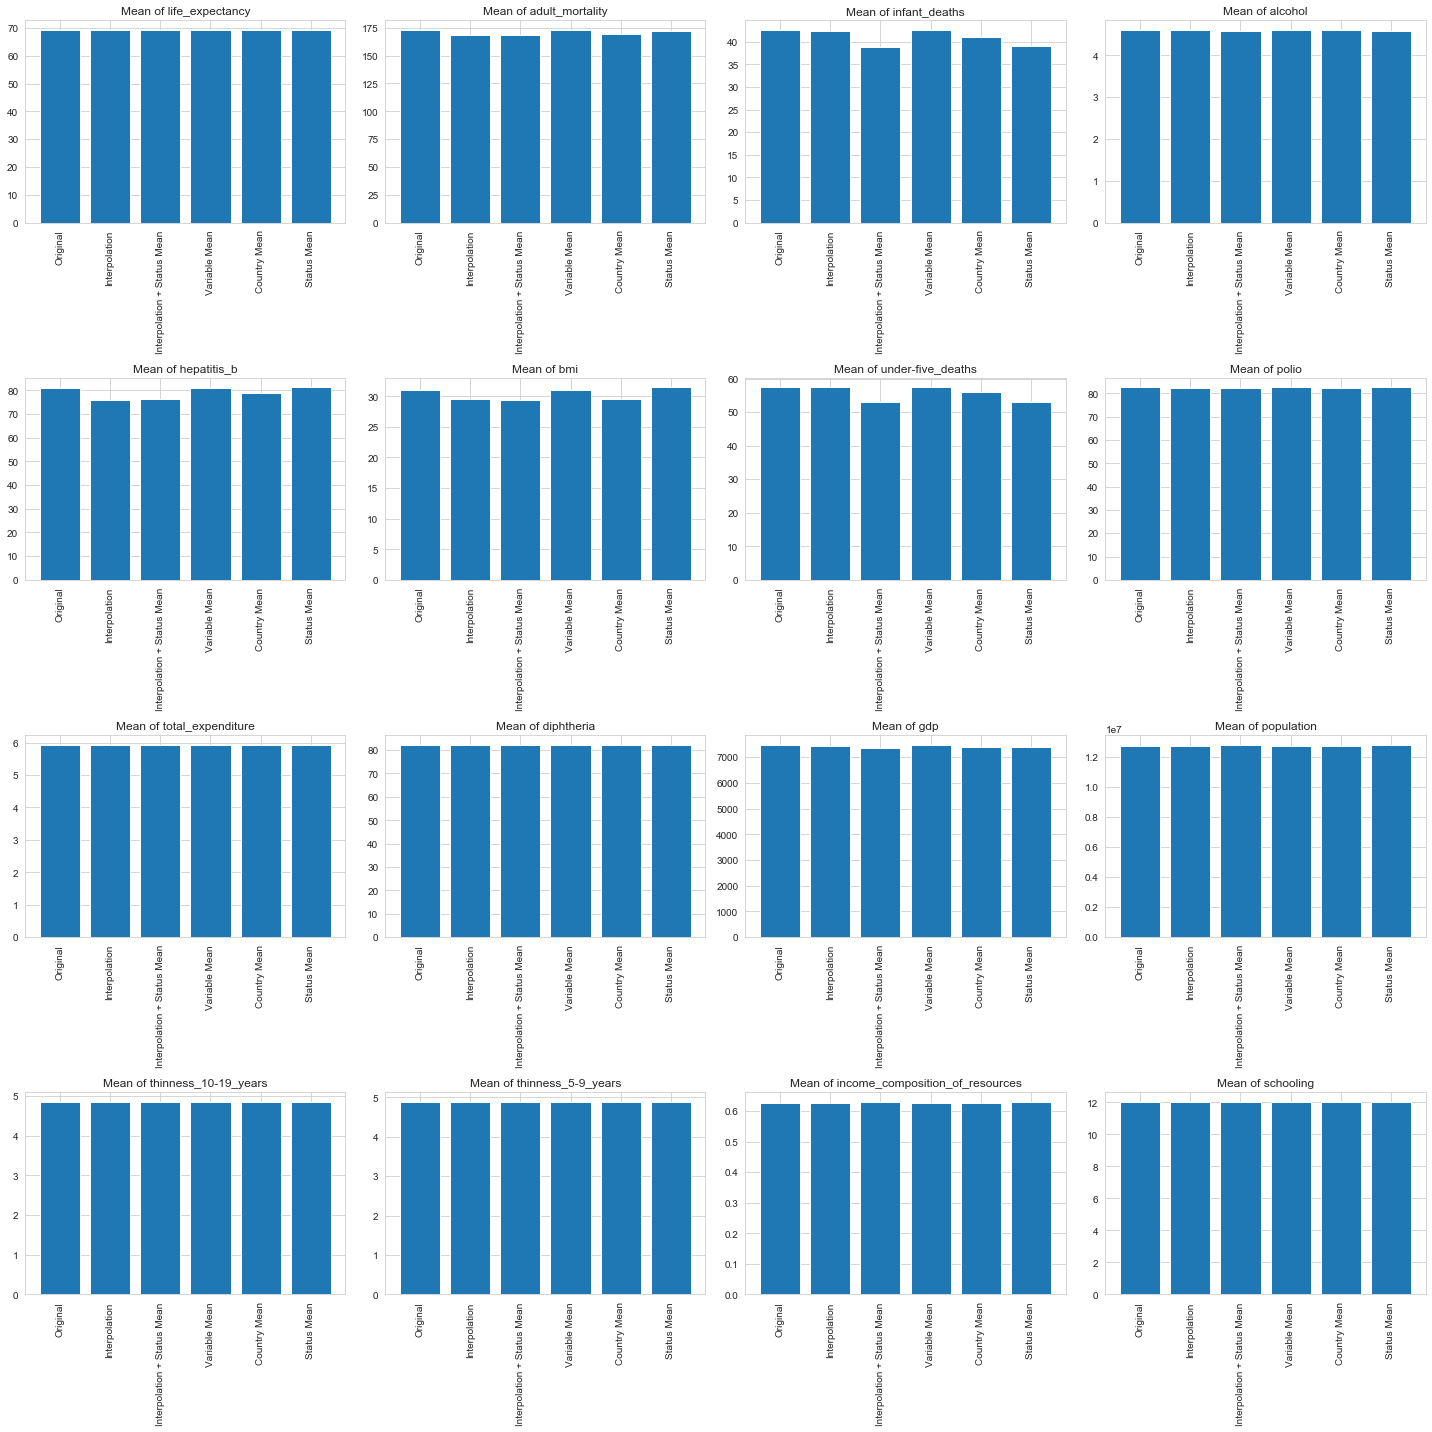

In [26]:
# Compare means for each missing value correction
plt.figure(figsize=(20, 20))

for i, column in enumerate(columns_to_fill):
    final_df = pd.concat([expectancy_df[column], expectancy_df1[column], expectancy_df2[column],
                          expectancy_df3[column], expectancy_df4[column], expectancy_df5[column]],
                         axis=1)
    
    plt.subplot(4, 4, i + 1)
    plt.bar(['Original', 'Interpolation', 'Interpolation + Status Mean', 'Variable Mean', 'Country Mean', 'Status Mean'], final_df.mean())
    plt.xticks(rotation='vertical')
    plt.title('Mean of {}'.format(column))

plt.tight_layout()
plt.show()

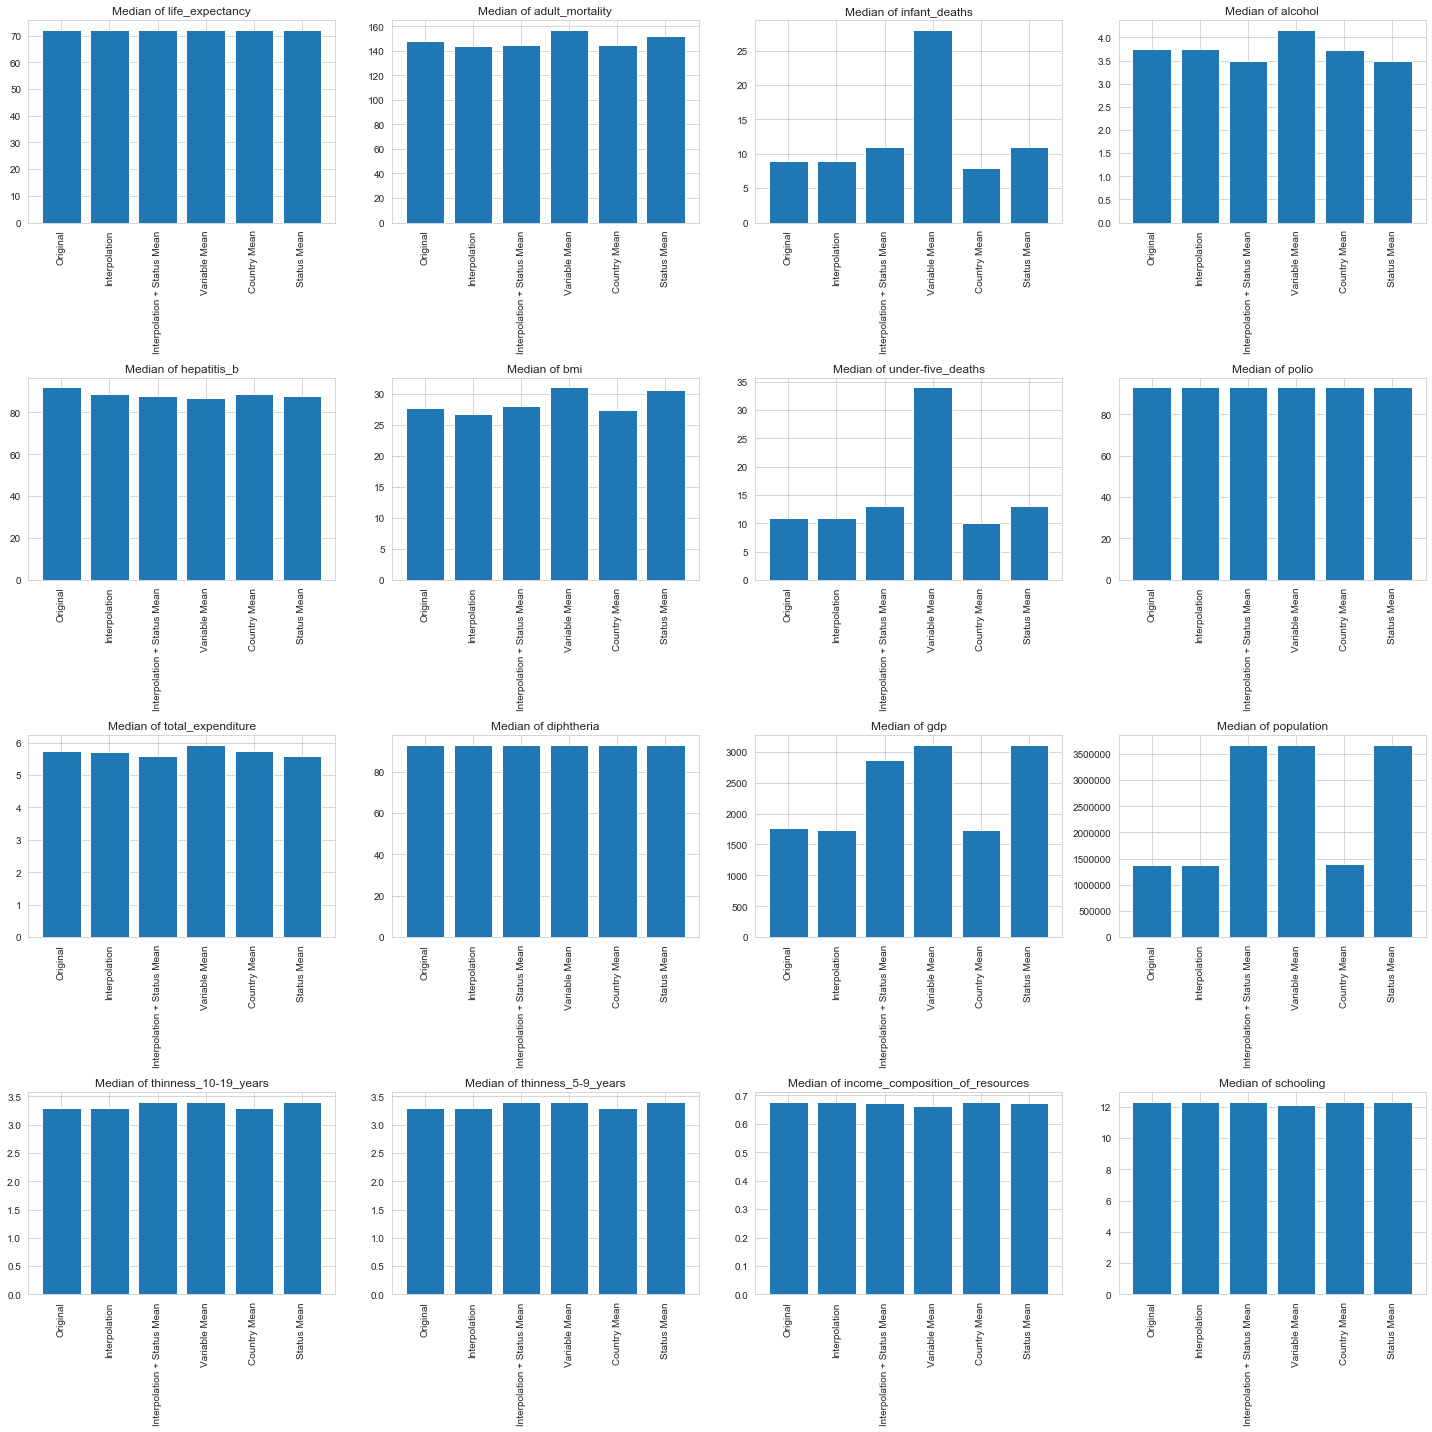

In [27]:
# Compare medians for each missing value correction
plt.figure(figsize=(20, 20))

for i, column in enumerate(columns_to_fill):
    final_df = pd.concat([expectancy_df[column], expectancy_df1[column], expectancy_df2[column],
                          expectancy_df3[column], expectancy_df4[column], expectancy_df5[column]],
                         axis=1)
    
    plt.subplot(4, 4, i + 1)
    plt.bar(['Original', 'Interpolation', 'Interpolation + Status Mean', 'Variable Mean', 'Country Mean', 'Status Mean'], final_df.median())
    plt.xticks(rotation='vertical')
    plt.title('Median of {}'.format(column))

plt.tight_layout()
plt.show()

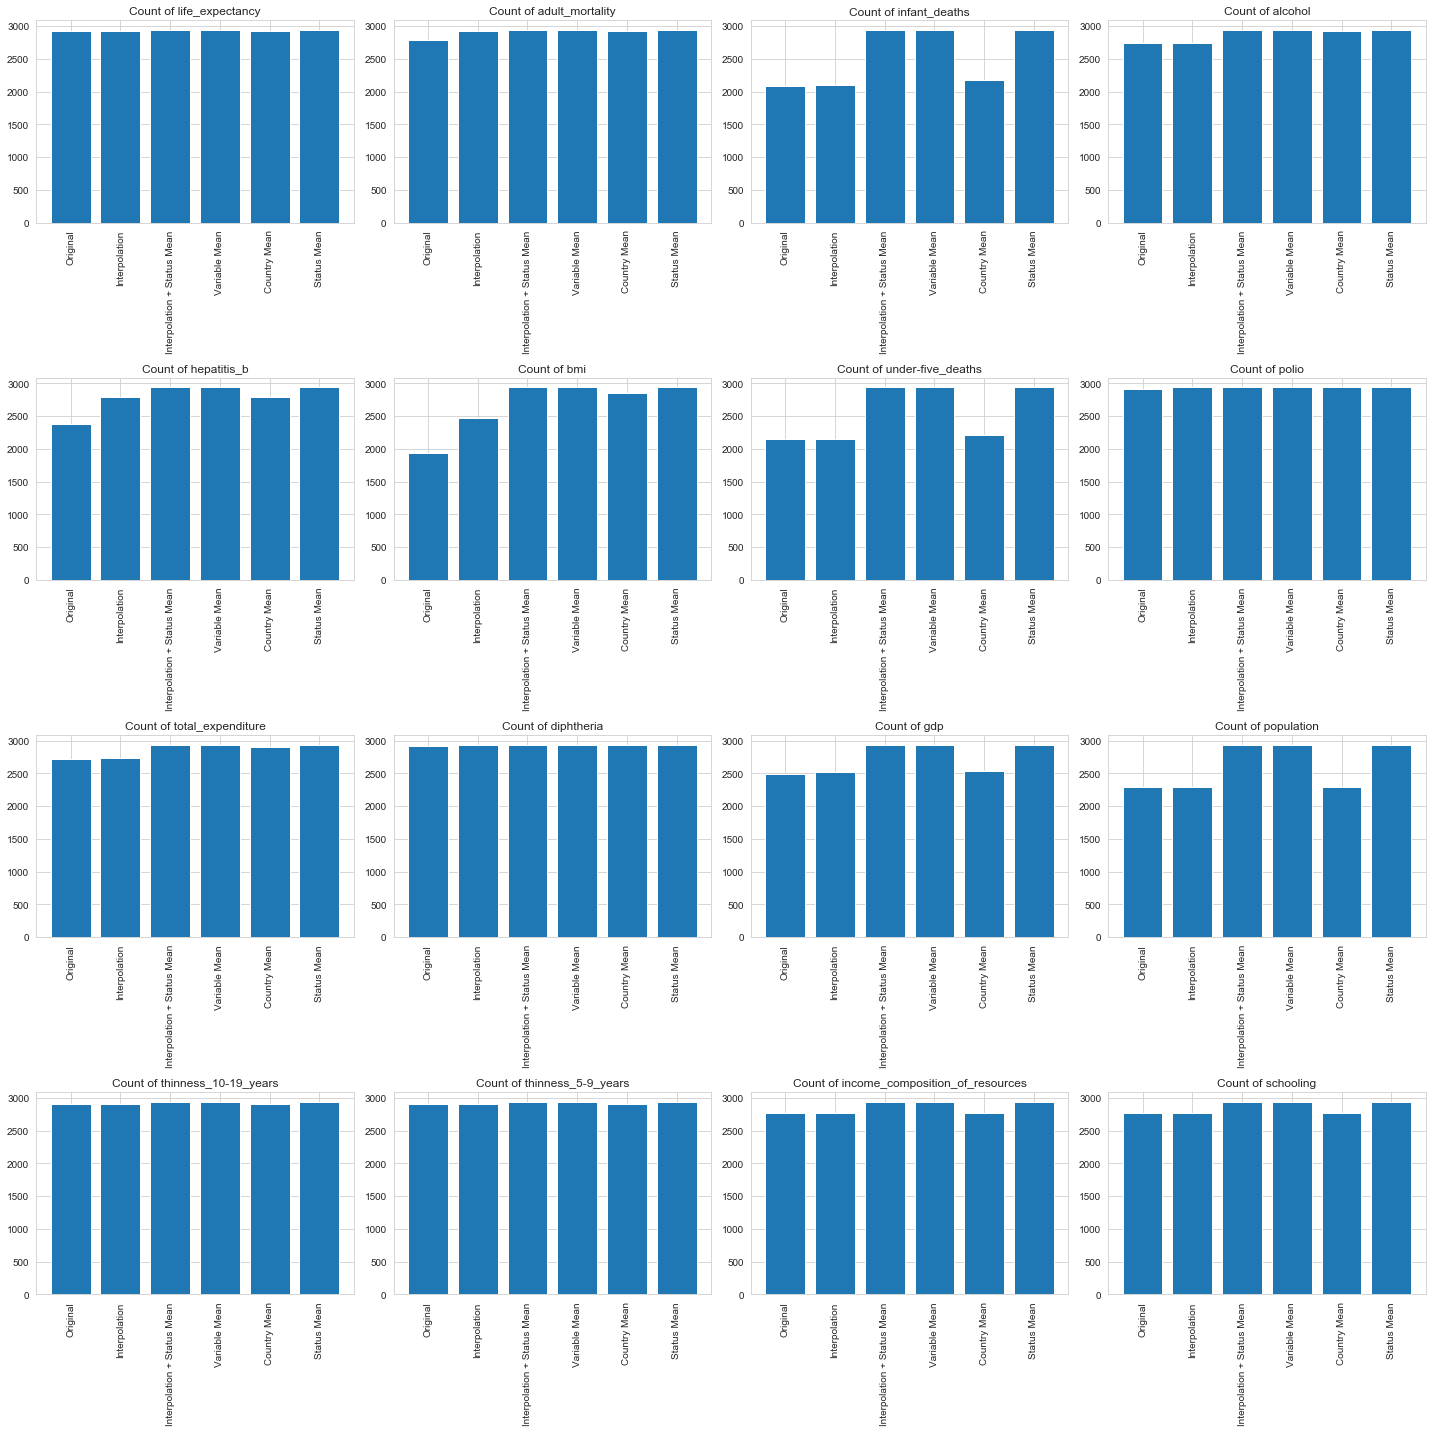

In [28]:
# Compare medians for each missing value correction
plt.figure(figsize=(20, 20))

for i, column in enumerate(columns_to_fill):
    final_df = pd.concat([expectancy_df[column], expectancy_df1[column], expectancy_df2[column],
                          expectancy_df3[column], expectancy_df4[column], expectancy_df5[column]],
                         axis=1)
    
    plt.subplot(4, 4, i + 1)
    plt.bar(['Original', 'Interpolation', 'Interpolation + Status Mean', 'Variable Mean', 'Country Mean', 'Status Mean'], final_df.count())
    plt.xticks(rotation='vertical')
    plt.title('Count of {}'.format(column))

plt.tight_layout()
plt.show()

First, I decided to use interpolation to fill in the missing values because the data is time series data (annual variables for countries around the world). Unfortunately, this technique did not fill in all of the missing values, likely because the missing values were part of a variable that was missing for all years for a given country. Rather than dropping the remaining missing values, I replaced them with the mean from countries of the same status (either developed or developing). I figured this was a better estimate than the overall variable mean because it would retain potentially meaningful differences between developed and developing countries.

    expectancy_df is the original data containing missing values
    expectancy_df2 is the corrected data I will be using moving forward (interpolation + status mean)

### Deal with Outliers

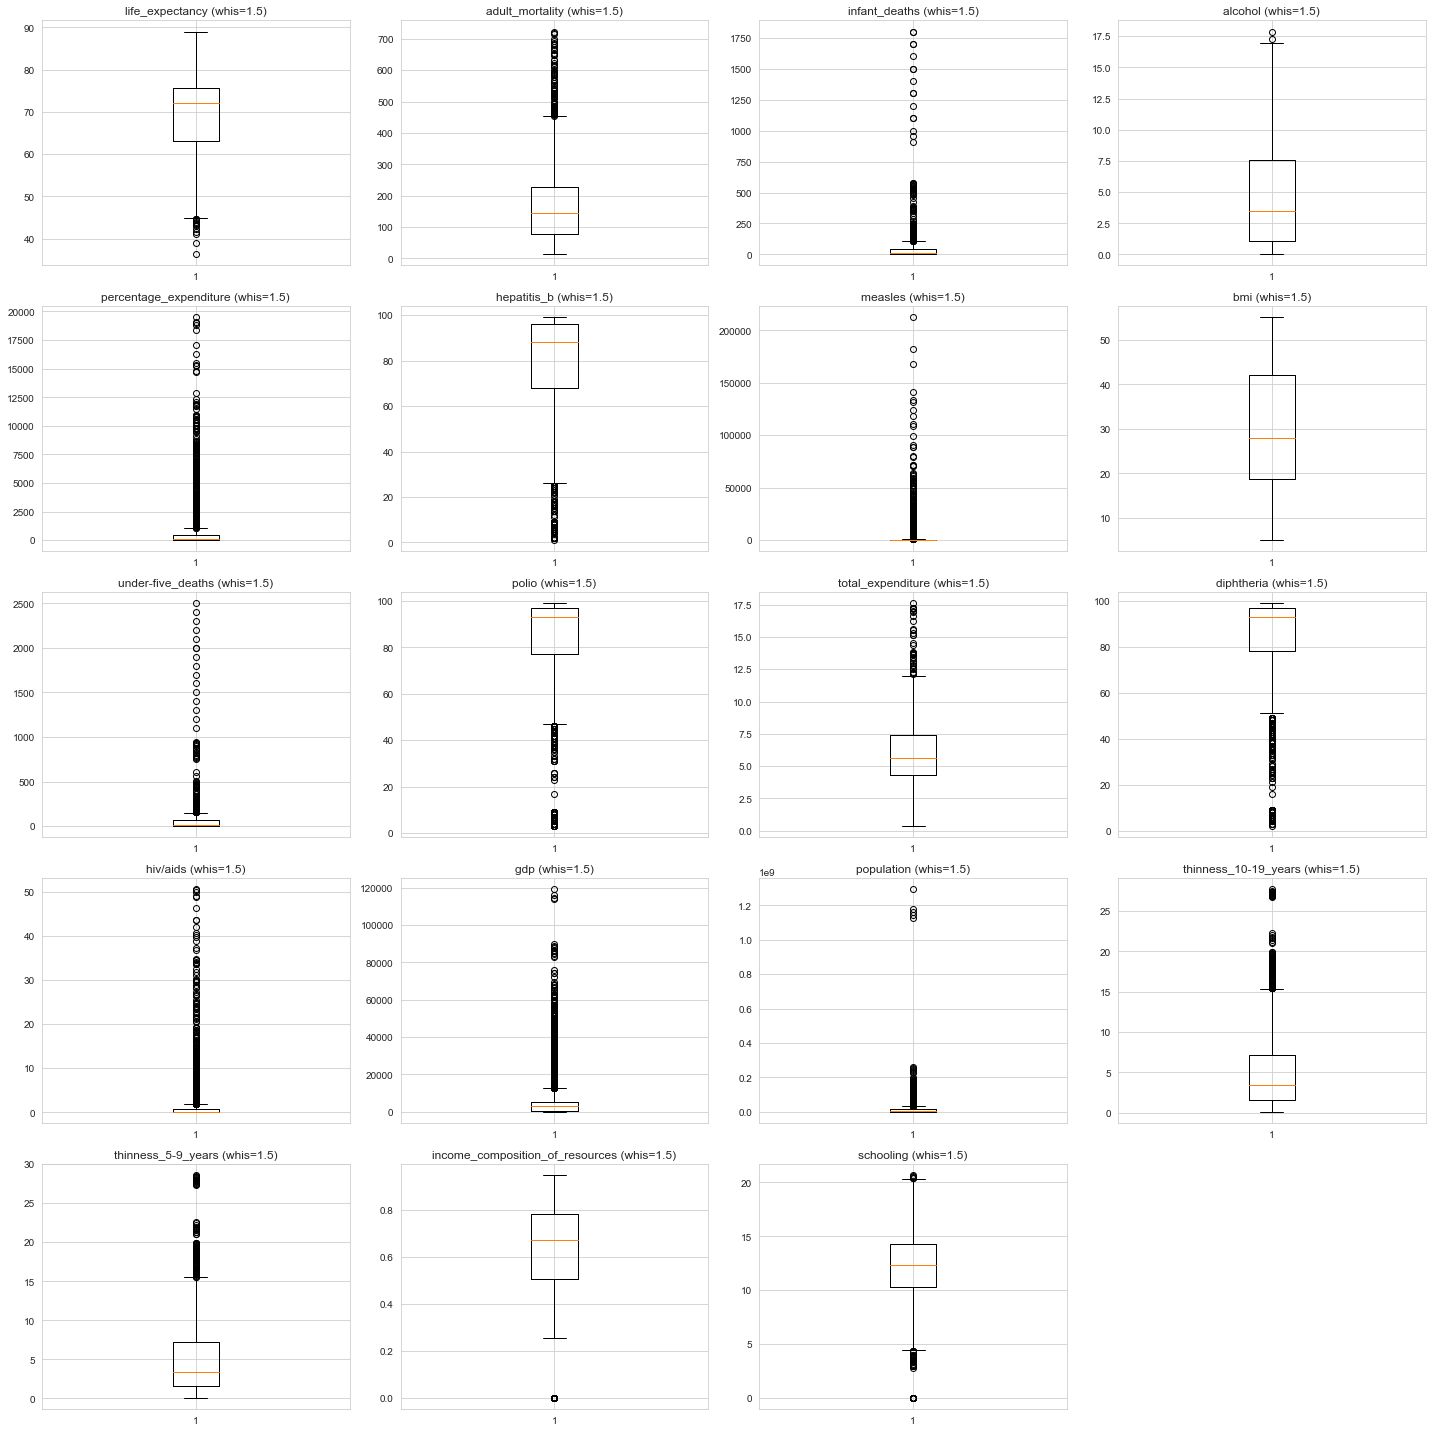

In [29]:
# Look for outliers visually
plt.figure(figsize=(20, 20))

data_columns = ['life_expectancy', 'adult_mortality', 'infant_deaths',
                'alcohol', 'percentage_expenditure', 'hepatitis_b',
                'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
                'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_10-19_years',
                'thinness_5-9_years', 'income_composition_of_resources', 'schooling']

for i, column in enumerate(data_columns):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(expectancy_df2[column], whis=1.5)
    plt.title('{} (whis=1.5)'.format(column))

plt.tight_layout()
plt.show()

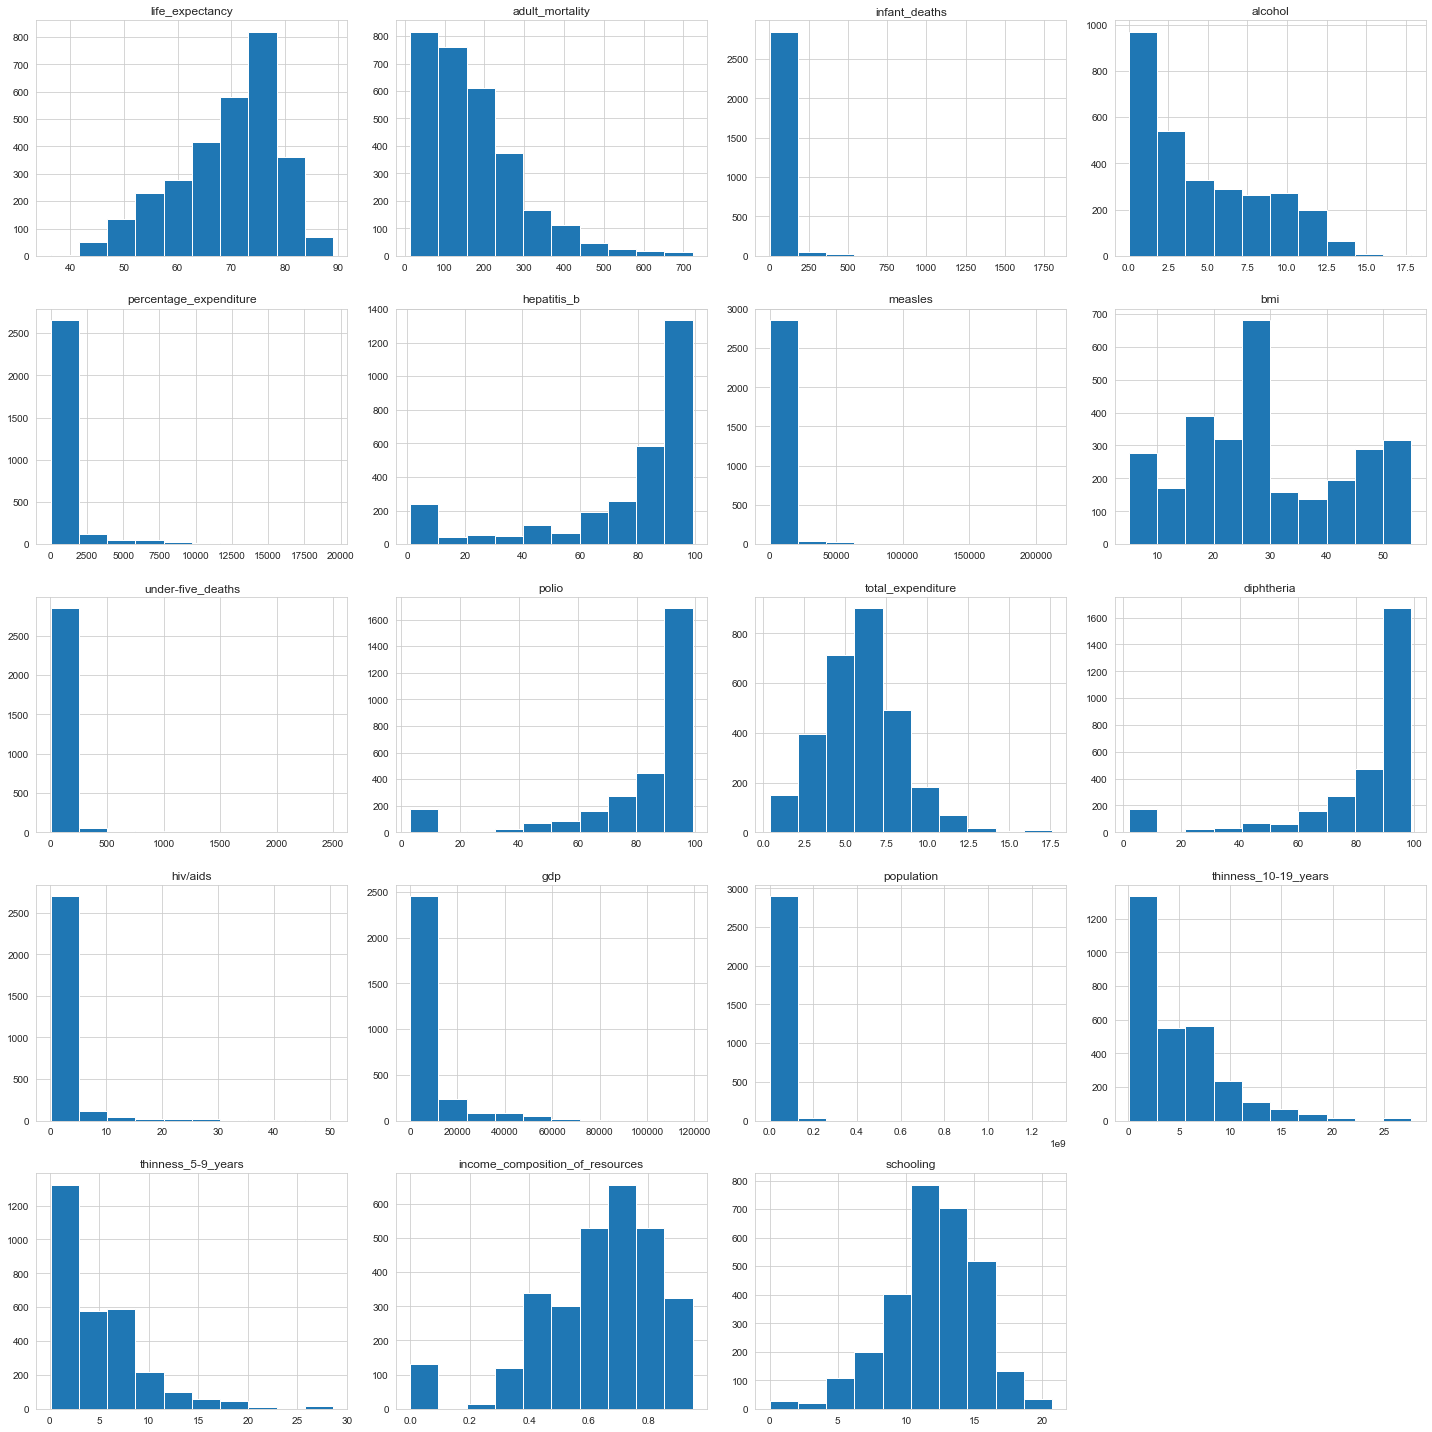

In [30]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(data_columns):
    plt.subplot(5, 4, i + 1)
    plt.hist(expectancy_df2[column])
    plt.title('{}'.format(column))

plt.tight_layout()
plt.show()

Outliers will possibly skew the downstream model and thus need to be dealt with now.

Based on the boxplots and histograms above, I am going to manually winsorize each variable to get rid of outliers (anything greater than 1.5 times the IQR). For variables without 0 values, I will compare winsorization vs. log transformation and pick the optimal solution.

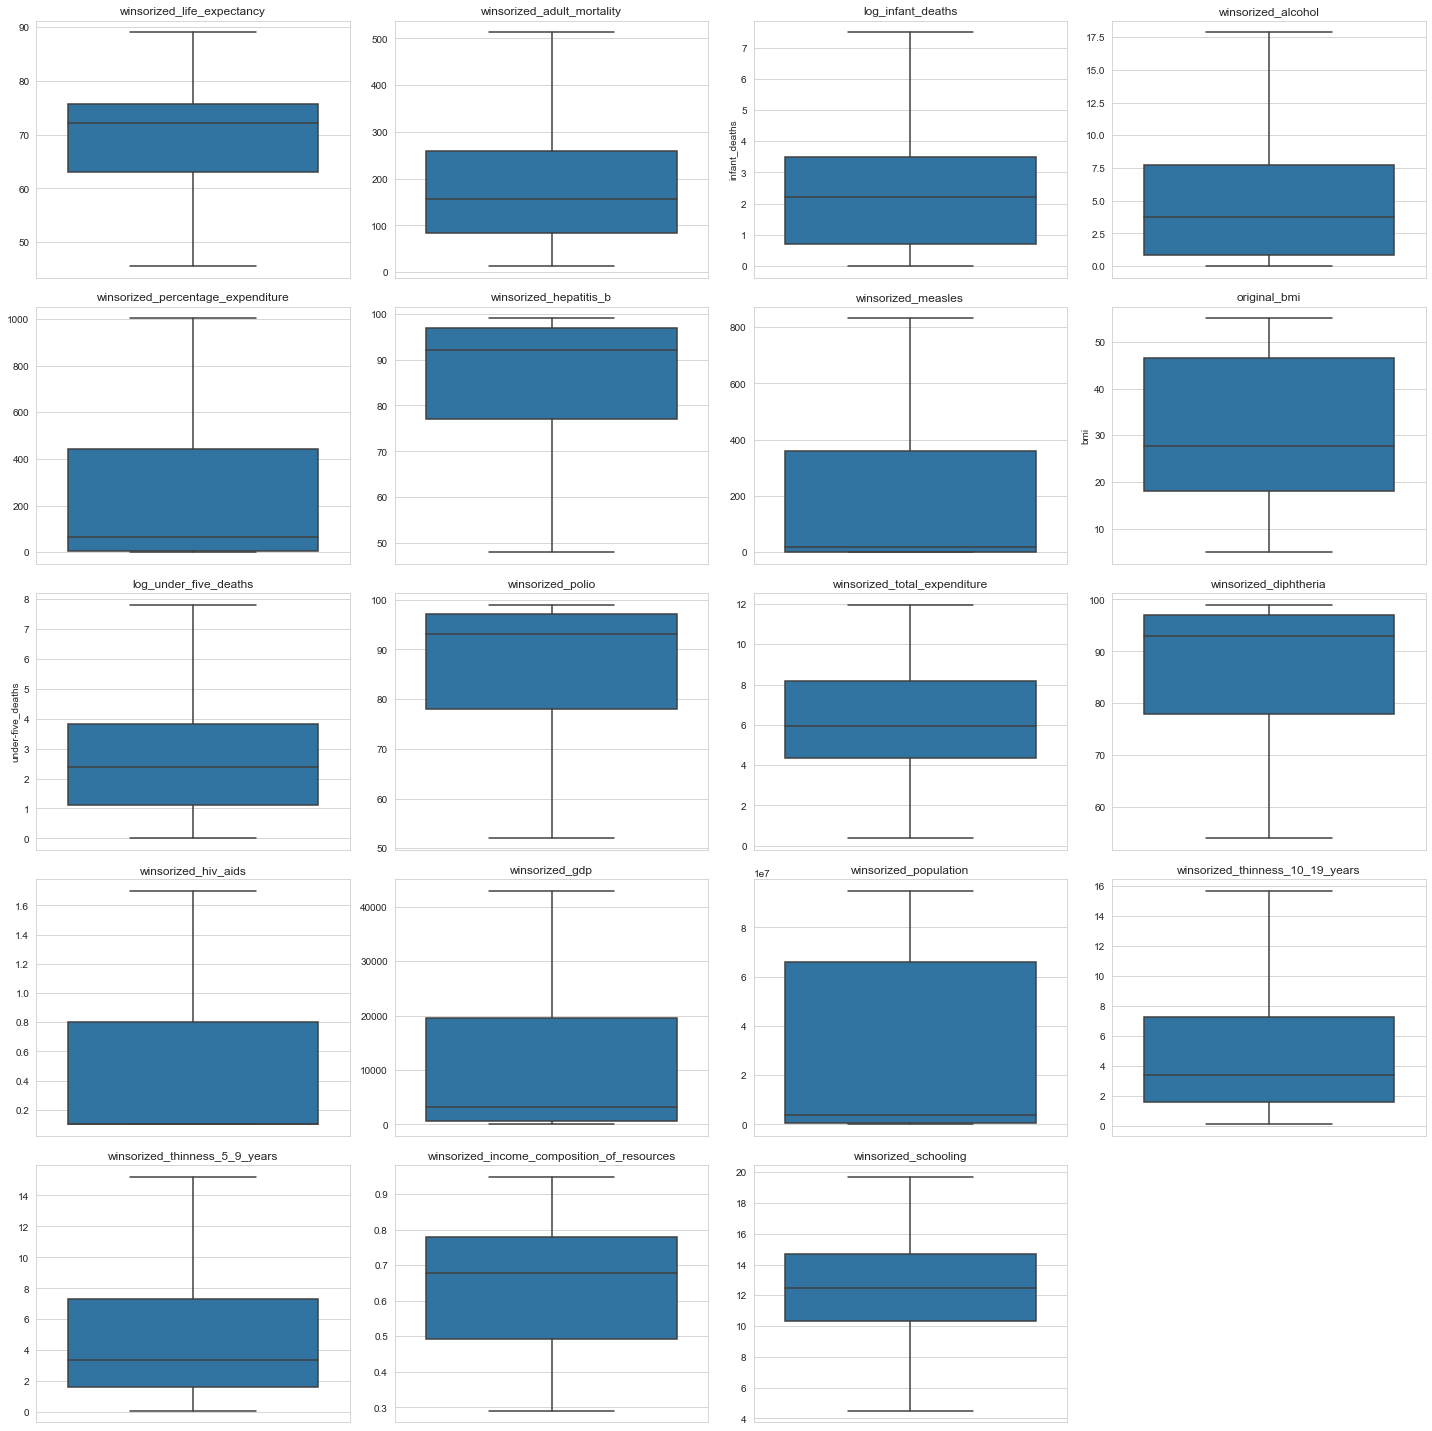

In [31]:
# Winsorize or log transform variables with outliers and plot transformed data
# Did not transform bmi (no outliers)
winsorized_life_expectancy = winsorize(expectancy_df['life_expectancy'], (0.01, 0))
winsorized_adult_mortality = winsorize(expectancy_df['adult_mortality'], (0, 0.07))
log_infant_deaths = np.log(expectancy_df['infant_deaths'])
winsorized_alcohol = winsorize(expectancy_df['alcohol'], (0, 0.01))
winsorized_percentage_expenditure = winsorize(expectancy_df['percentage_expenditure'], (0, 0.14))
winsorized_hepatitis_b = winsorize(expectancy_df['hepatitis_b'], (0.09, 0))
winsorized_measles = winsorize(expectancy_df['measles'], (0, 0.19))
original_bmi = expectancy_df['bmi']
log_under_five_deaths = np.log(expectancy_df['under-five_deaths'])
winsorized_polio = winsorize(expectancy_df['polio'], (0.10, 0))
winsorized_total_expenditure = winsorize(expectancy_df['total_expenditure'], (0, 0.09))
winsorized_diphtheria = winsorize(expectancy_df['diphtheria'], (0.11, 0))
winsorized_hiv_aids = winsorize(expectancy_df['hiv/aids'], (0, 0.19))
winsorized_gdp = winsorize(expectancy_df['gdp'], (0, 0.19))
winsorized_population = winsorize(expectancy_df['population'], (0, 0.24))
winsorized_thinness_10_19_years = winsorize(expectancy_df['thinness_10-19_years'], (0, 0.04))
winsorized_thinness_5_9_years = winsorize(expectancy_df['thinness_5-9_years'], (0, 0.05))
winsorized_income_composition_of_resources = winsorize(expectancy_df['income_composition_of_resources'], (0.05, 0))
winsorized_schooling = winsorize(expectancy_df['schooling'], (0.02, 0.06))

transformed_data = [winsorized_life_expectancy, winsorized_adult_mortality,
                  log_infant_deaths, winsorized_alcohol,
                  winsorized_percentage_expenditure, winsorized_hepatitis_b,
                  winsorized_measles, original_bmi, log_under_five_deaths,
                  winsorized_polio, winsorized_total_expenditure, winsorized_diphtheria,
                  winsorized_hiv_aids, winsorized_gdp, winsorized_population,
                  winsorized_thinness_10_19_years, winsorized_thinness_5_9_years,
                  winsorized_income_composition_of_resources, winsorized_schooling]

titles = ['winsorized_life_expectancy', 'winsorized_adult_mortality',
        'log_infant_deaths', 'winsorized_alcohol',
        'winsorized_percentage_expenditure', 'winsorized_hepatitis_b',
        'winsorized_measles', 'original_bmi', 'log_under_five_deaths',
        'winsorized_polio', 'winsorized_total_expenditure', 'winsorized_diphtheria',
        'winsorized_hiv_aids', 'winsorized_gdp', 'winsorized_population',
        'winsorized_thinness_10_19_years', 'winsorized_thinness_5_9_years',
        'winsorized_income_composition_of_resources', 'winsorized_schooling']

plt.figure(figsize=(20, 20))

for i, column in enumerate(transformed_data):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(column, orient='v', whis=1.5).set_title(titles[i])

plt.tight_layout()
plt.show()

## Explore Data

### Univariate Analysis

In [32]:
# Make new data frame with transformed data
original_country = expectancy_df['country']
original_year = expectancy_df['year']
original_status = expectancy_df['status']

final_columns = [original_country, original_year, original_status,
                 winsorized_life_expectancy, winsorized_adult_mortality,
                 log_infant_deaths, winsorized_alcohol,
                 winsorized_percentage_expenditure, winsorized_hepatitis_b,
                 winsorized_measles, original_bmi, log_under_five_deaths,
                 winsorized_polio, winsorized_total_expenditure, winsorized_diphtheria,
                 winsorized_hiv_aids, winsorized_gdp, winsorized_population,
                 winsorized_thinness_10_19_years, winsorized_thinness_5_9_years,
                 winsorized_income_composition_of_resources, winsorized_schooling]

final_variables = ['country', 'year', 'status',
                 'life_expectancy', 'adult_mortality',
                 'infant_deaths', 'alcohol',
                 'percentage_expenditure', 'hepatitis_b',
                 'measles', 'bmi', 'under_five_deaths',
                 'polio', 'total_expenditure', 'diphtheria',
                 'hiv_aids', 'gdp', 'population',
                 'thinness_10_19_years', 'thinness_5_9_years',
                 'income_composition_of_resources', 'schooling']

df = pd.DataFrame()

for i, column in enumerate(final_columns):
    df[final_variables[i]] = column

In [33]:
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,4.127134,0.01,71.279624,65.0,831,...,52.0,8.16,65.0,0.1,584.259210,33736494.0,15.7,15.2,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,4.158883,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,15.7,15.2,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,4.189655,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,15.7,15.2,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,4.234107,0.01,78.184215,67.0,831,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,15.7,15.2,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,4.262680,0.01,7.097109,68.0,831,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,15.7,15.2,0.454,9.5


In [34]:
# Descriptive statistics for transformed data
df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling
count,2938.000000,2928.000000,2938.000000,2090.000000,2744.000000,2938.000000,2385.000000,2938.000000,1932.000000,2153.000000,2919.000000,2938.000000,2919.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2771.000000,2938.000000
mean,2007.518720,69.242008,189.389040,2.265571,4.602861,271.234472,84.242348,220.691287,31.080280,2.436058,85.547448,6.371542,85.724221,0.508237,12284.599142,2.801013e+07,4.841695,4.829135,0.641306,12.468822
std,4.613841,9.477572,136.823015,1.655922,4.052413,363.172291,16.648003,329.192321,15.413593,1.774267,15.313238,2.808932,14.789302,0.640847,16683.479544,3.940520e+07,4.130285,4.091031,0.176217,3.565360
min,2000.000000,45.600000,13.000000,0.000000,0.010000,0.000000,48.000000,0.000000,5.000000,0.000000,52.000000,0.370000,54.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,4.500000
25%,2004.000000,63.100000,84.000000,0.693147,0.877500,4.685343,77.000000,0.000000,18.000000,1.098612,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.493000,10.300000
50%,2008.000000,72.100000,157.000000,2.197225,3.755000,64.912906,92.000000,17.000000,27.800000,2.397895,93.000000,5.950000,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.677000,12.500000
75%,2012.000000,75.700000,259.000000,3.496508,7.702500,441.534144,97.000000,360.250000,46.500000,3.828641,97.000000,8.190000,97.000000,0.800000,19482.273660,6.610275e+07,7.300000,7.300000,0.779000,14.700000
max,2015.000000,89.000000,513.000000,7.495542,17.870000,1002.833273,99.000000,831.000000,55.000000,7.824046,99.000000,11.970000,99.000000,1.700000,42955.242870,9.488772e+07,15.700000,15.200000,0.948000,19.700000


In [35]:
# Descriptive statistics for text-based variables only
df.describe(include=['O'])

,country,status
count,2938,2938
unique,193,2
top,Comoros,Developing
freq,16,2426


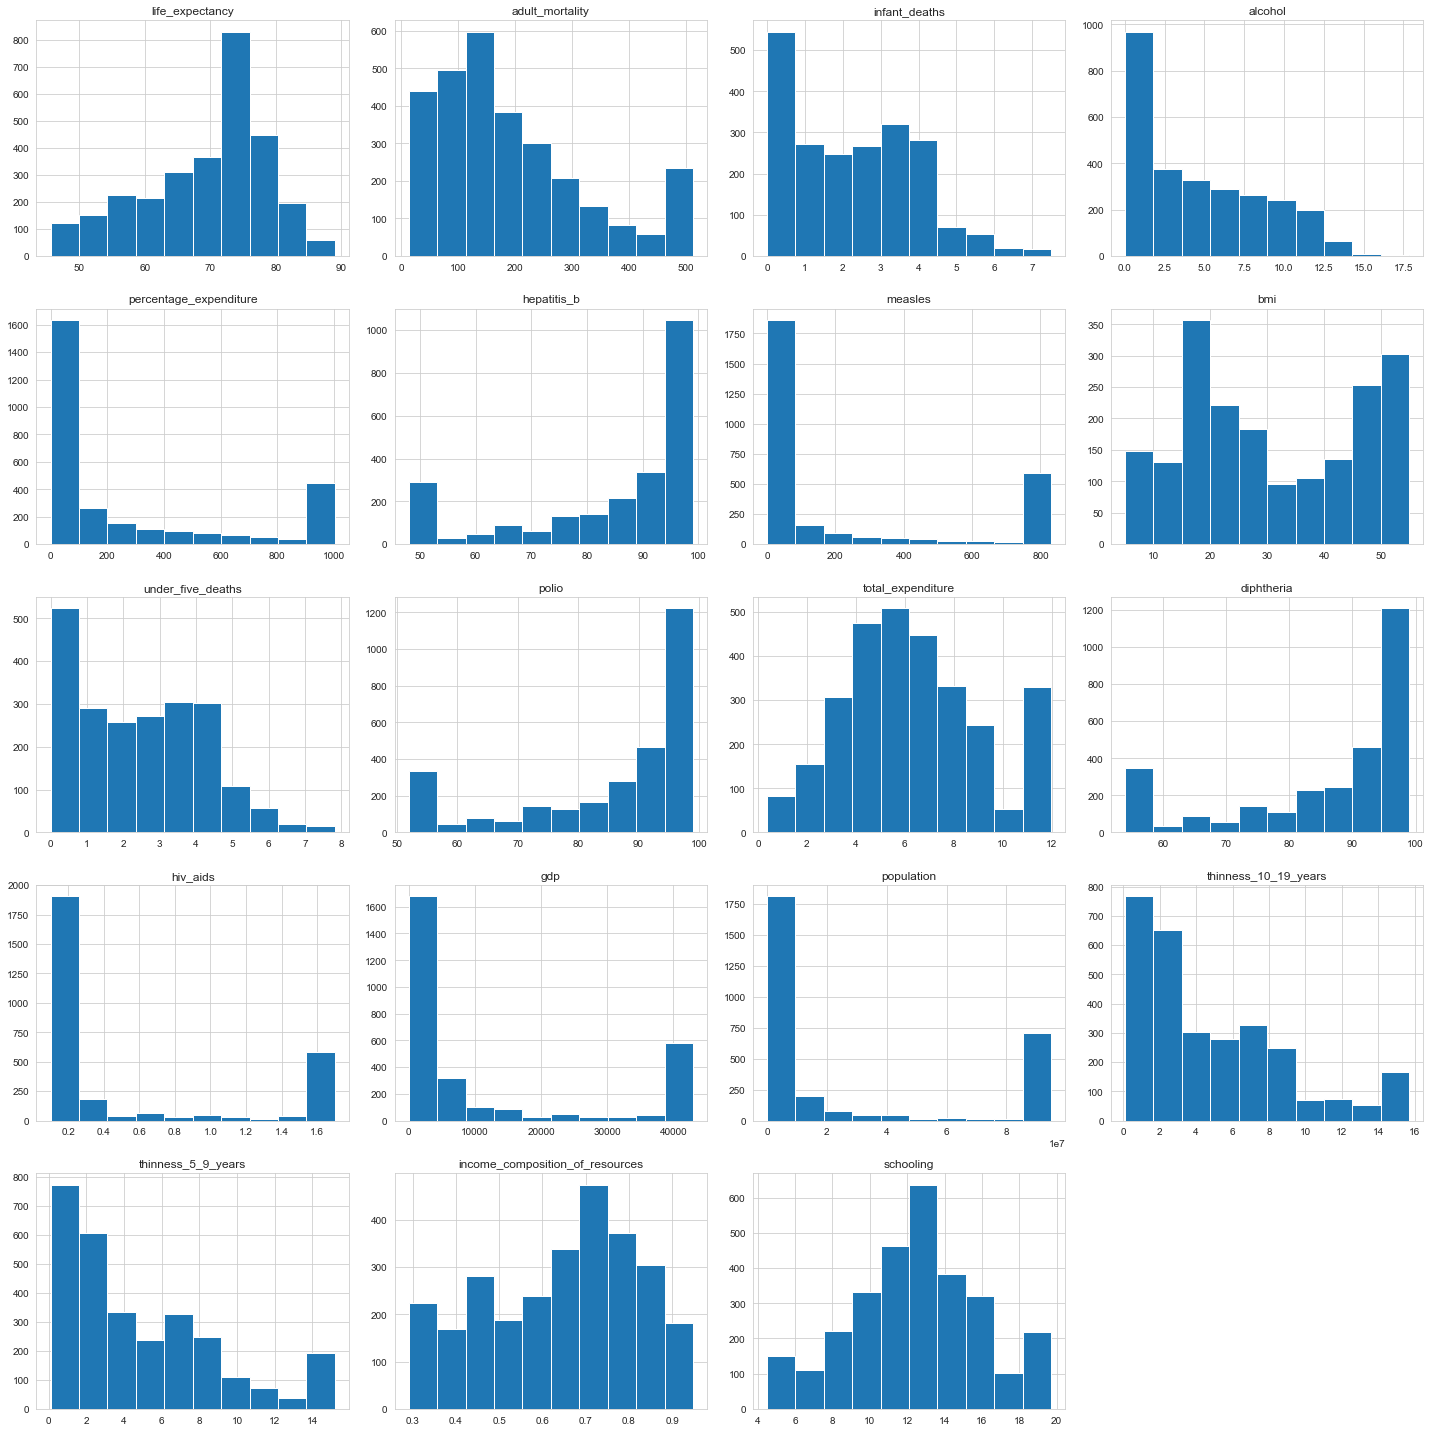

In [36]:
# Visualize distributions of continuous variables
continuous_var = list(df.columns)[3:]

plt.figure(figsize=(20, 20))

for i, column in enumerate(continuous_var):
    plt.subplot(5, 4, i + 1)
    plt.hist(df[column])
    plt.title('{}'.format(column))

plt.tight_layout()
plt.show()

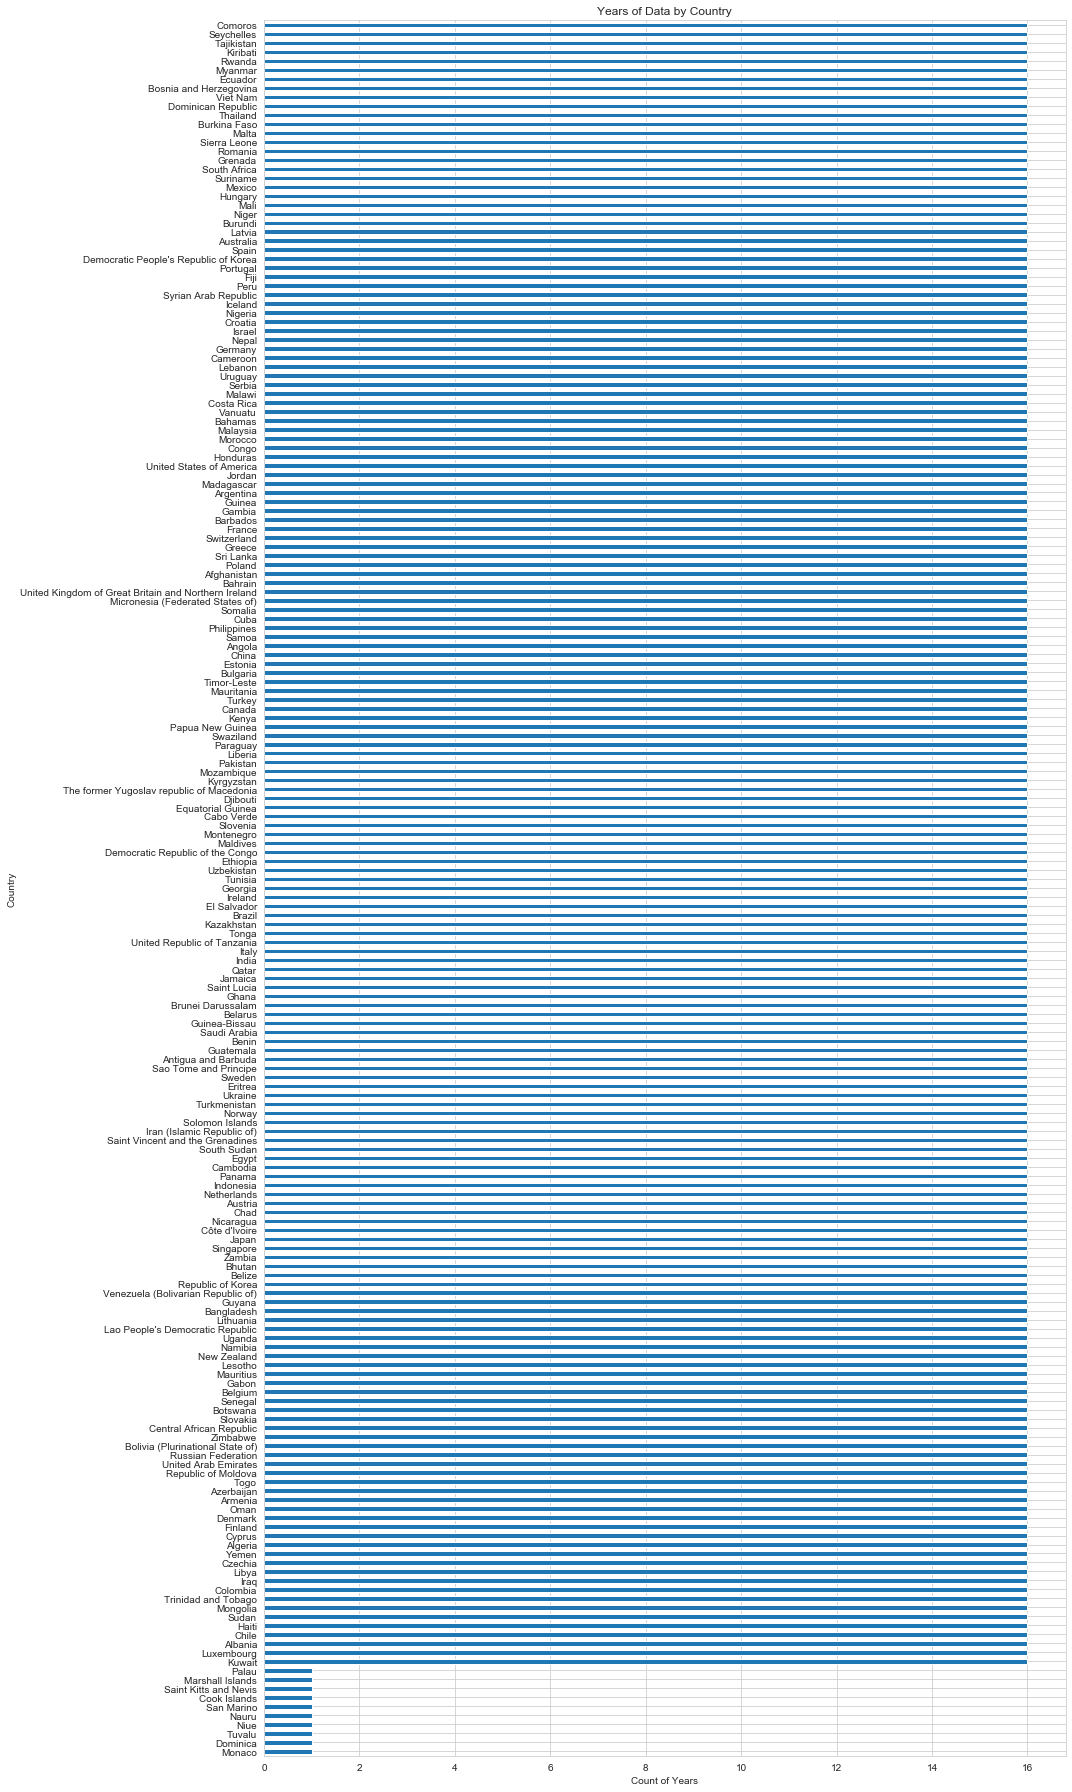

In [37]:
# Visualize categorical variables
plt.figure(figsize=(15, 25))

df['country'].value_counts(ascending=True).plot(kind='barh')

plt.title('Years of Data by Country')
plt.xlabel('Count of Years')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

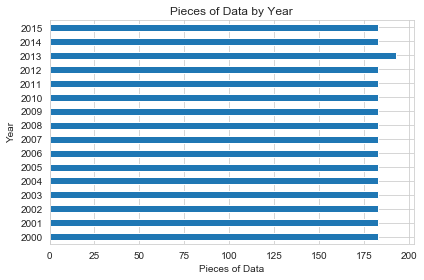

In [38]:
# Visualize categorical variables
df['year'].value_counts().sort_index().plot(kind='barh')

plt.title('Pieces of Data by Year')
plt.xlabel('Pieces of Data')
plt.ylabel('Year')

plt.tight_layout()
plt.show()

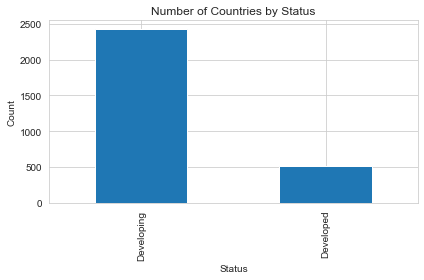

In [39]:
df['status'].value_counts().plot(kind='bar')

plt.title('Number of Countries by Status')
plt.xlabel('Status')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Multivariate Analysis

In [40]:
# Look at correlation matrix
df.corr()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling
year,1.000000,0.169366,-0.059812,-0.032082,-0.052990,0.033419,0.108800,-0.118772,-0.060097,-0.046995,0.116045,0.271352,0.147621,-0.087581,0.057427,0.022961,-0.044756,-0.045569,0.214583,0.175886
life_expectancy,0.169366,1.000000,-0.497108,-0.503504,0.406550,0.489383,0.324421,-0.337691,0.403749,-0.556142,0.576466,0.175252,0.585343,-0.797360,0.265842,0.091245,-0.526526,-0.530374,0.827898,0.619255
adult_mortality,-0.059812,-0.497108,1.000000,0.197228,-0.120012,-0.163744,-0.162767,0.154880,-0.193767,0.227998,-0.232160,-0.054993,-0.240640,0.436914,-0.084956,-0.045422,0.234272,0.239766,-0.364659,-0.228054
infant_deaths,-0.032082,-0.503504,0.197228,1.000000,-0.327088,-0.376910,-0.324616,0.509733,-0.383733,0.995225,-0.403348,-0.125925,-0.407749,0.314321,-0.075193,0.149266,0.433246,0.441277,-0.512983,-0.354483
alcohol,-0.052990,0.406550,-0.120012,-0.327088,1.000000,0.391316,0.119057,-0.201020,0.216518,-0.354176,0.273331,0.269418,0.283708,-0.202639,0.234131,-0.036022,-0.450277,-0.442674,0.514871,0.513657
percentage_expenditure,0.033419,0.489383,-0.163744,-0.376910,0.391316,1.000000,0.125037,-0.197055,0.217456,-0.400047,0.269190,0.024616,0.273167,-0.299011,0.189131,-0.122539,-0.336087,-0.339920,0.564047,0.371913
hepatitis_b,0.108800,0.324421,-0.162767,-0.324616,0.119057,0.125037,1.000000,-0.263749,0.199415,-0.349649,0.663679,0.067040,0.726305,-0.271498,0.083958,0.109813,-0.133406,-0.139864,0.303176,0.261805
measles,-0.118772,-0.337691,0.154880,0.509733,-0.201020,-0.197055,-0.263749,1.000000,-0.315173,0.522181,-0.322168,-0.142819,-0.320298,0.226950,-0.069566,0.057568,0.363110,0.366792,-0.282227,-0.243464
bmi,-0.060097,0.403749,-0.193767,-0.383733,0.216518,0.217456,0.199415,-0.315173,1.000000,-0.393111,0.308970,0.060472,0.300408,-0.334672,0.081520,0.028193,-0.428894,-0.427732,0.382284,0.241740
under_five_deaths,-0.046995,-0.556142,0.227998,0.995225,-0.354176,-0.400047,-0.349649,0.522181,-0.393111,1.000000,-0.443050,-0.122366,-0.449127,0.375113,-0.080339,0.140268,0.451184,0.458405,-0.568969,-0.394533


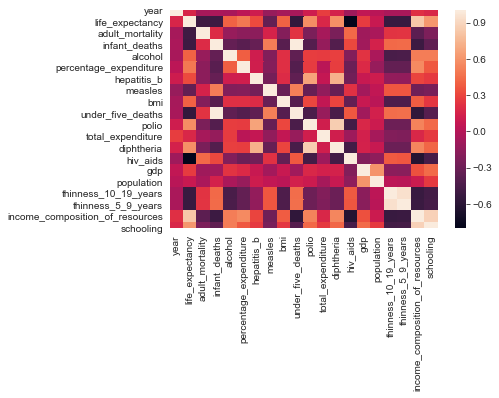

In [41]:
sns.heatmap(df.corr())
plt.show()

Life expectancy is highly positively correlated with:

    -income_composition_of_resources (0.827898)
    -schooling (0.619255)
    -diphtheria (0.585343)
    -polio (0.576466)
    -percentage_expenditure (0.489383)
    -alcohol(0.406550)
    -bmi (0.403749)
    
Life expectancy is highly negatively correlated with:

    -hiv_aids (-0.797360)
    -under_five_deaths (-0.556142)
    -thinness_5_9_years (-0.530374)
    -thinness_10_19_years (-0.526526)
    -infant_deaths (-0.503504)
    -adult_mortality (-0.497108)
    
The following variables are highly positively correlated with each other:

    -thinness_10_19_years and thinness_5_9_years (0.946125)
    -infant_deaths and under_five_deaths (0.995225)
    -polio and diphtheria (0.859002)
    -hepatitis_b and polio (0.663679)
    -hebatitis_b and diphtheria (0.726305)
    -gdp and population (0.603528)
    -schooling and income_composition_of_resources (0.875110)

Total expenditure, gdp, and population have very little correlation with life expectancy.

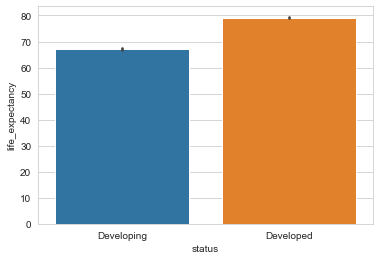

79.19785156249996 67.13216059602664


In [42]:
# Look at effect of status on life expectancy
sns.barplot(x='status', y='life_expectancy', data=df, orient='v')

plt.show()

developed = df[df['status'] == 'Developed']['life_expectancy']
developing = df[df['status'] == 'Developing']['life_expectancy']
stats.ttest_ind(developed.dropna(), developing.dropna())
print(developed.mean(), developing.mean())

Developed countries have a significantly higher life expectancy than developing countries (79.2 vs. 67.1)

## Feature Engineering

Based on the above analyses, I have selected the following variables that I think would be ideal in the modeling phase:

    -status
    -income_composition_of_resources (0.827898)
    -diphtheria (0.585343)
    -percentage_expenditure (0.489383)
    -alcohol (0.406550)
    -bmi (0.403749)
    -hiv_aids (-0.797360)
    -under_five_deaths (-0.556142)
    -thinness_5_9_years (-0.530374)
    -adult_mortality (-0.497108)
    
I dropped year, total_expenditure, gdp, and population because they appear to be unrelated to life expectancy.

I dropped thinness_10_19_years because it is highly correlated with thinness_5_9_years.

I dropped infant_deaths because it is highly correlated with under_five_deaths.

I dropped polio because it is highly correlated with diphtheria.

I dropped schooling because it is highly correlated with income_composition_of_resources.

In [53]:
feature_df = df.copy()

columns_to_drop = ['country', 'year', 'infant_deaths',
                   'hepatitis_b', 'measles', 'polio', 'total_expenditure',
                   'gdp', 'population', 'thinness_10_19_years', 'schooling']

for column in columns_to_drop:
    feature_df.drop(column, axis=1, inplace=True)

feature_df

,status,life_expectancy,adult_mortality,alcohol,percentage_expenditure,bmi,under_five_deaths,diphtheria,hiv_aids,thinness_5_9_years,income_composition_of_resources
0,Developing,65.0,263.0,0.01,71.279624,19.1,4.418841,65.0,0.1,15.2,0.479
1,Developing,59.9,271.0,0.01,73.523582,18.6,4.454347,62.0,0.1,15.2,0.476
2,Developing,59.9,268.0,0.01,73.219243,18.1,4.488636,64.0,0.1,15.2,0.470
3,Developing,59.5,272.0,0.01,78.184215,17.6,4.532599,67.0,0.1,15.2,0.463
4,Developing,59.2,275.0,0.01,7.097109,17.2,4.574711,68.0,0.1,15.2,0.454
...,...,...,...,...,...,...,...,...,...,...,...
2933,Developing,45.6,513.0,4.36,0.000000,27.1,3.737670,65.0,1.7,9.4,0.407
2934,Developing,45.6,513.0,4.06,0.000000,26.7,3.713572,68.0,1.7,9.9,0.418
2935,Developing,45.6,73.0,4.43,0.000000,26.3,3.688879,71.0,1.7,1.3,0.427
2936,Developing,45.6,513.0,1.72,0.000000,25.9,3.663562,75.0,1.7,1.7,0.427


In [54]:
feature_df.corr()

,life_expectancy,adult_mortality,alcohol,percentage_expenditure,bmi,under_five_deaths,diphtheria,hiv_aids,thinness_5_9_years,income_composition_of_resources
life_expectancy,1.000000,-0.497108,0.406550,0.489383,0.403749,-0.556142,0.585343,-0.797360,-0.530374,0.827898
adult_mortality,-0.497108,1.000000,-0.120012,-0.163744,-0.193767,0.227998,-0.240640,0.436914,0.239766,-0.364659
alcohol,0.406550,-0.120012,1.000000,0.391316,0.216518,-0.354176,0.283708,-0.202639,-0.442674,0.514871
percentage_expenditure,0.489383,-0.163744,0.391316,1.000000,0.217456,-0.400047,0.273167,-0.299011,-0.339920,0.564047
bmi,0.403749,-0.193767,0.216518,0.217456,1.000000,-0.393111,0.300408,-0.334672,-0.427732,0.382284
under_five_deaths,-0.556142,0.227998,-0.354176,-0.400047,-0.393111,1.000000,-0.449127,0.375113,0.458405,-0.568969
diphtheria,0.585343,-0.240640,0.283708,0.273167,0.300408,-0.449127,1.000000,-0.479755,-0.302106,0.543661
hiv_aids,-0.797360,0.436914,-0.202639,-0.299011,-0.334672,0.375113,-0.479755,1.000000,0.367176,-0.622392
thinness_5_9_years,-0.530374,0.239766,-0.442674,-0.339920,-0.427732,0.458405,-0.302106,0.367176,1.000000,-0.522743
income_composition_of_resources,0.827898,-0.364659,0.514871,0.564047,0.382284,-0.568969,0.543661,-0.622392,-0.522743,1.000000


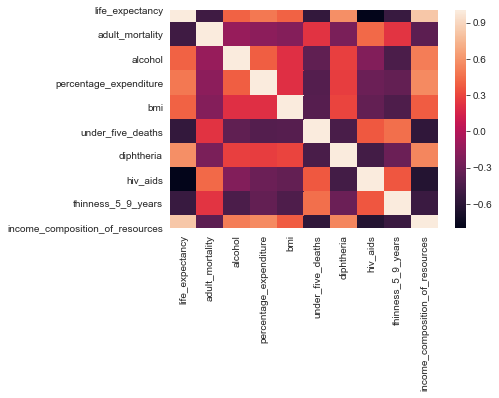

In [55]:
sns.heatmap(feature_df.corr())
plt.show()

## Summary

I started with the life expectancy dataset from kaggle, which consists of 22 variables, including the target variable of life expectancy. First, I standardized the column names by removing unnecessary spaces, making the text lowercase, and correcting typos. Next, I analyzed the data for potential errors by looking at the descriptive statistics for each variable (primarily min and max values), as well as variable types, unique data entries and counts, and percent missing values. Using this information, I replaced potentially incorrect values with null (as indicated above) and then replaced the null values using interpolation followed by replacement with the mean from countries of the same status (developed or developing).

Next, I eliminated outliers (1.5 times IQR) from the continuous variables using either manual winsorization () or log transformation (). I then analyzed the newly transformed data using both univariate and multivariate analyses. In brief, in the univariate analyses, I found that all but 10 countries in the dataset included data for all 16 years (2000 to 2015) and that the dataset was biased towards developed countries rather than developing countries. In the multivariate analyses, I was able to identify the variables most closely correlated with life expectancy (positive or negative), as well as those varibles that had seemingly no correlation with life expectancy. I was also able to identify the correlation between variables.

Finally, using the multivariate analyses results, I selected 10 features/variables to predict life expectancy, namely status, adult mortality, alcohol, percentage expenditure, bmi, under_five_deaths, diphtheria, hiv_aids, thinness 5-9 years, and income composition of resources.


When I was stuck, I turned to https://www.kaggle.com/philbowman212/life-expectancy-exploratory-data-analysis for help.